#### Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

plt.style.use('seaborn')
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('D202.csv')

In [3]:
data.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [4]:
data.TYPE.unique()

array(['Electric usage'], dtype=object)

In [5]:
data.shape

(70368, 8)

In [6]:
data = data[['DATE', 'USAGE']]

In [7]:
data.head()

,DATE,USAGE
0,10/22/2016,0.01
1,10/22/2016,0.01
2,10/22/2016,0.01
3,10/22/2016,0.01
4,10/22/2016,0.01


In [8]:
data.isnull().sum()

DATE     0
USAGE    0
dtype: int64

In [9]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [10]:
data.head()

,DATE,USAGE
0,2016-10-22,0.01
1,2016-10-22,0.01
2,2016-10-22,0.01
3,2016-10-22,0.01
4,2016-10-22,0.01


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    70368 non-null  datetime64[ns]
 1   USAGE   70368 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 MB


In [12]:
print('Minimum Tanggal :', min(data['DATE']))
print('Maksimum Tanggal :', max(data['DATE']))

Minimum Tanggal : 2016-10-22 00:00:00
Maksimum Tanggal : 2018-10-24 00:00:00


In [13]:
df = pd.DataFrame(data.groupby('DATE')['USAGE'].sum())

In [14]:
df.head()

,USAGE
DATE,
2016-10-22,4.52
2016-10-23,23.32
2016-10-24,7.16
2016-10-25,8.68
2016-10-26,5.04


In [15]:
df2 = df.reset_index()

In [16]:
df2['year'] = df2['DATE'].dt.year
df2['month'] = df2['DATE'].dt.month

In [17]:
df2['year'] = df2['year'].astype('str')
df2['month'] = df2['month'].astype('str')

df2['year-month'] = df2['year'] + df2['month']
df2.head()

,DATE,USAGE,year,month,year-month
0,2016-10-22,4.52,2016,10,201610
1,2016-10-23,23.32,2016,10,201610
2,2016-10-24,7.16,2016,10,201610
3,2016-10-25,8.68,2016,10,201610
4,2016-10-26,5.04,2016,10,201610


In [18]:
df2 = pd.DataFrame(df2.groupby('year-month')['USAGE'].sum())

In [19]:
df2.head()

,USAGE
year-month,
201610,85.60
201611,404.36
201612,624.52
20171,742.40
201710,217.04


### EDA

Text(0, 0.5, 'Usage')

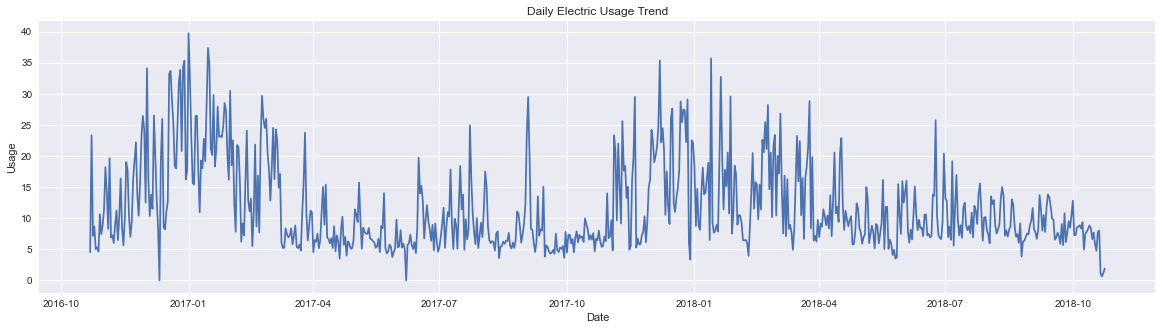

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(df['USAGE'])
plt.title('Daily Electric Usage Trend')
plt.xlabel('Date')
plt.ylabel('Usage')

Text(0, 0.5, 'Usage')

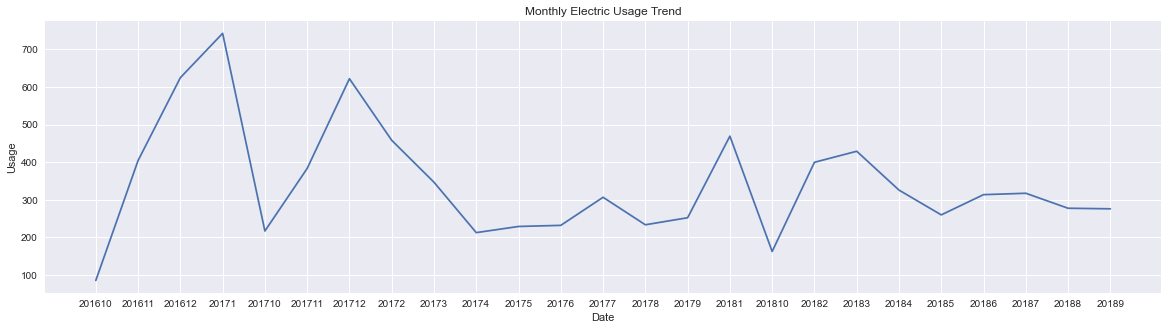

In [21]:
plt.figure(figsize=(20, 5))
plt.plot(df2['USAGE'])
plt.title('Monthly Electric Usage Trend')
plt.xlabel('Date')
plt.ylabel('Usage')

<AxesSubplot:xlabel='USAGE', ylabel='Density'>

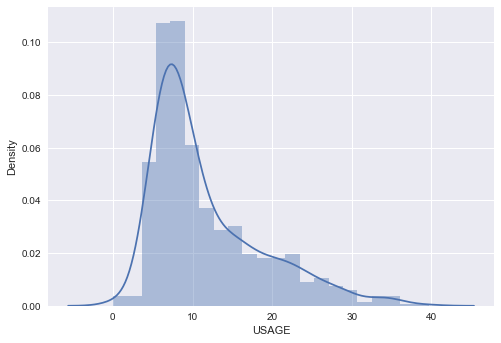

In [22]:
sns.distplot(df['USAGE'])

<AxesSubplot:xlabel='USAGE'>

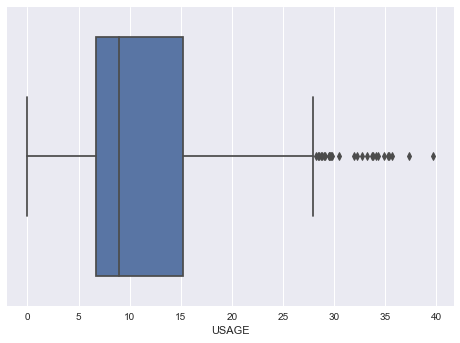

In [23]:
sns.boxplot(df['USAGE'])

### Data Preparation

In [24]:
def series_to_supervised(data, n_in):
    df = pd.DataFrame(data)
    cols = []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        
    cols.append(df.shift(0))

    agg = pd.concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

In [25]:
transform = series_to_supervised(df['USAGE'].values, n_in=30)

In [26]:
transform.shape

(703, 31)

In [27]:
print('training count :', round(transform.shape[0]*0.8))
print('testing count :', df.shape[0] - round(transform.shape[0]*0.8))

training count : 562
testing count : 171


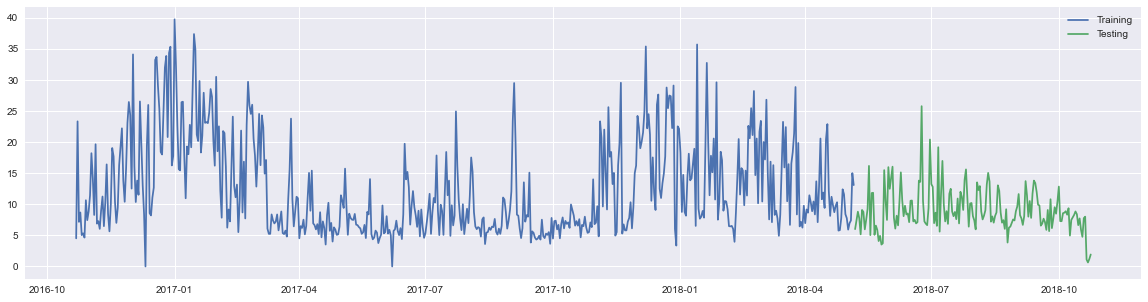

In [28]:
plt.figure(figsize=(20, 5))
plt.plot(df['USAGE'][:-171], label='Training')
plt.plot(df['USAGE'][-171:], label = 'Testing')
plt.legend()

In [60]:
train, test = transform[:-171, :], transform[-171:, :]

In [30]:
predictions = []
history = [x for x in train]

### Modeling

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [34]:
train = np.asarray(history)

In [35]:
X_train, y_train = train[:, :-1], train[:, -1]

In [36]:
model_xgb = XGBRegressor()
model_rf = RandomForestRegressor()
model_dt = DecisionTreeRegressor()

In [37]:
model_xgb.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [45]:
pred_xgb = []
pred_rf = []
pred_dt = []

for i in range(len(test)):
    pred_xgb.append(model_xgb.predict(np.asarray([test[i, :-1]])))
    pred_rf.append(model_rf.predict(np.asarray([test[i, :-1]])))
    pred_dt.append(model_dt.predict(np.asarray([test[i, :-1]])))

#### Evaluation

XGBoost

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

In [47]:
evaluation = {
    'Model' : ['Xgboost', 'RandomForest', 'DecisionTree'],
    'MAE' : [],
    'RMSE' : [],
    'MAPE' : []
}

In [63]:
predictions = [pred_xgb, pred_rf, pred_dt]

for pred in predictions:
    evaluation['MAE'].append(mean_absolute_error(test[:, -1], pred))
    evaluation['RMSE'].append(rmse(test[:, -1], pred))
    evaluation['MAPE'].append(mape(test[:, -1], pred))

In [65]:
pd.DataFrame(evaluation).sort_values(by='MAPE')

,Model,MAE,RMSE,MAPE
1,RandomForest,2.757076,3.672734,52.979406
0,Xgboost,3.033152,4.186501,57.246496
2,DecisionTree,4.141754,5.570544,66.997790


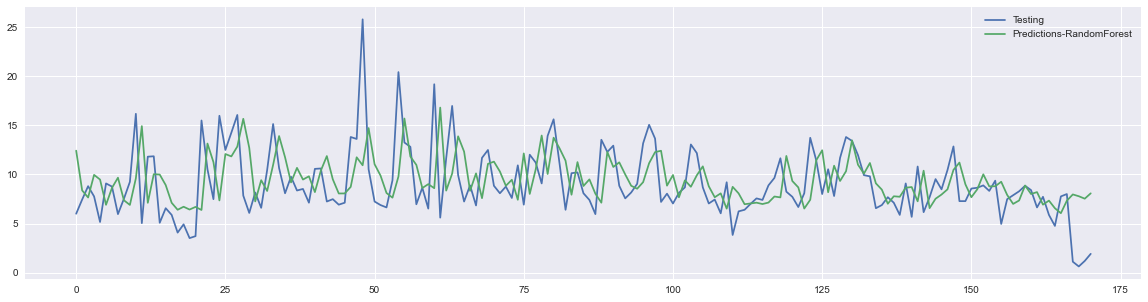

In [69]:
plt.figure(figsize=(20, 5))
plt.plot(test[:,-1], label='Testing')
plt.plot(pred_rf, label='Predictions-RandomForest')
plt.legend()

### Forecast

In [73]:
values = df['USAGE'].values

In [74]:
train = series_to_supervised(values, n_in=30)

trainX, trainy = train[:, :-1], train[:, -1]

In [75]:
model = RandomForestRegressor()
model.fit(trainX, trainy)

RandomForestRegressor()

In [81]:
forecast = []
nilai = list(values)

for i in range(30):
    row = np.asarray(nilai[-30:]).flatten()
    yhat = model.predict(np.asarray([row]))
    nilai.append(yhat)
    forecast.append(yhat)
print('Selesai')

Selesai


In [88]:
hasil_forecast = []

for i in range(len(forecast)):
    hasil_forecast.append(forecast[i][0])

In [95]:
rng = pd.date_range('2018-10-25', periods=30, freq='D')
df_fc = pd.DataFrame({'DATE':rng, 'forecast':hasil_forecast})

In [98]:
df_fc.set_index('DATE', inplace=True)

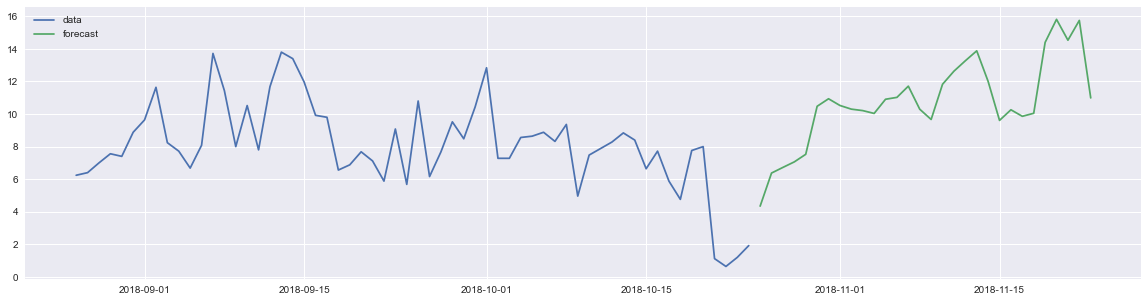

In [102]:
plt.figure(figsize=(20,5))
plt.plot(df['USAGE'][-60:], label='data')
plt.plot(df_fc['forecast'], label='forecast')
plt.legend()